In [1]:
pip install -e custom_envs 

Obtaining file:///C:/Users/HP/Downloads/CS698R-ARCHI-GUPTA-21111014-ASSIGN-1-main/CS698R-ARCHI-GUPTA-21111014-ASSIGN-1-main/custom_envs
  Attempting uninstall: my-envs
    Found existing installation: my-envs 0.0.1
    Uninstalling my-envs-0.0.1:
      Successfully uninstalled my-envs-0.0.1
  Running setup.py develop for my-envs
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym 
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)


## generate trajectory function

In [3]:
def generateTrajectory(env, pi, maxSteps):
  t=[]
  for i in range(maxSteps):
    s = env.state
    a = pi[s-1]
    ns, r, done = env.step(pi[s-1])
    t.append((s, a, r, ns))
    if done: break
  if done == False: t=[]  ## discard trajectory if not done within maxSteps
  env.reset()
  return t

## decay function 
with example plots

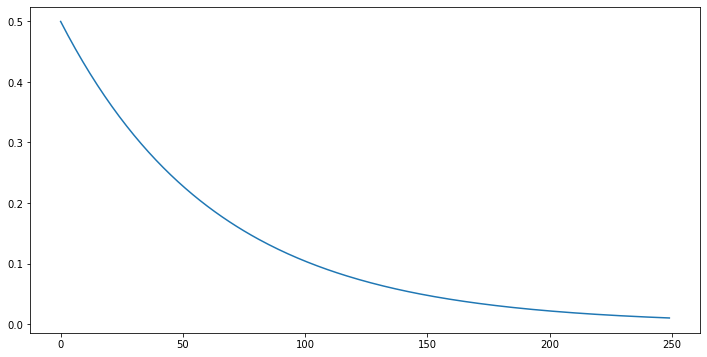

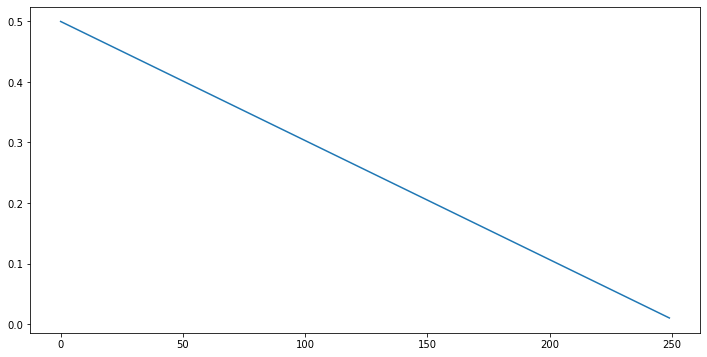

In [4]:
def decayAlpha(initial, final, maxSteps, type):
  if type=='linear':
    m = (final - initial)/(maxSteps-1) 
    return np.arange(initial, final+m, m)
  if type=='exponential':
    k = math.log(final/initial)/(maxSteps-1)
    f = lambda x: initial*(math.exp(k)**x)
    return f(np.arange(maxSteps))

plt.figure(0)
plt.plot(decayAlpha(0.5, 0.01, 250,'exponential')) 
plt.figure(1)
plt.plot(decayAlpha(0.5, 0.01, 250,'linear')) 


## Monte Carlo Prediction Algorithm
Inputs : env, policy (pi), episodes, firstvisit (boolean), alpha (initial step size value), b (discount factor)

Outputs : Value estimates and MC Target for all episodes

This function always uses exponential alpha decay (till 0.01) for first half of episodes


In [5]:
def MonteCarlo(env, pi, maxSteps, EPISODES, firstvisit, alpha, b):
  v = np.zeros(len(env.observation_space))
  v_r = np.zeros((EPISODES, len(env.observation_space)))
  target = np.zeros((EPISODES, len(env.observation_space)))
  alpha = decayAlpha(alpha, 0.01, EPISODES/2, 'exponential')

  for e in range(EPISODES):
    t = generateTrajectory(env,pi,maxSteps)
    visited = np.zeros(len(env.observation_space))
    for i, (s,a,r,ns) in enumerate(t):
      if visited[s] and firstvisit: continue
      g=0
      for j in range(i,len(t)):
        g += (b**(i-j))*t[j][2]
      v[s] += alpha[min(e,len(alpha)-1)]*(g-v[s])
      target[e][s]=g
      #visited[s] = 1
    v_r[e]=v

  return v_r, target

## Temporal Difference Prediction Algorithm

Inputs : env, policy (pi), episodes, alpha (initial step size value), b (discount factor)

Outputs : Value estimates and MC Target for all episodes

This function always uses exponential alpha decay (till 0.01) for first half of episodes

In [6]:
def TemporalDifference(env, pi, maxSteps, EPISODES, alpha, b):
  v = np.zeros(len(env.observation_space))
  v_r = np.zeros((EPISODES, len(env.observation_space)))
  target = np.zeros((EPISODES, len(env.observation_space)))
  alpha = decayAlpha(alpha, 0.01, EPISODES/2, 'exponential')
  
  for e in range(EPISODES):
    s,done = env.state, False
    while not done:
      a = pi[s-1]
      ns, r, done = env.step(a)
      td_target = r
      if not done : td_target = td_target + b*v[ns]
      td_error = td_target - v[s]
      v[s] = v[s] + alpha[min(e,len(alpha)-1)]*td_error
      s=ns
      target[e][s] = td_target
    v_r[e]=v
    env.reset()

  return v_r, target

## Running the agents

In [8]:
rwe = gym.make('my_envs:random-walk-v0',seed=1234)
pi=[1,1,1,1,1]
mcfv, mcfv_target = MonteCarlo(rwe, pi, 10, 500, True, 0.5, 0.99)
mcev, mcev_target = MonteCarlo(rwe, pi, 10, 500, False, 0.5, 0.99)
td, td_target = TemporalDifference(rwe, pi, 10, 500, 0.5, 0.99)

## Plotting value estimates 

#### MC-FVMC

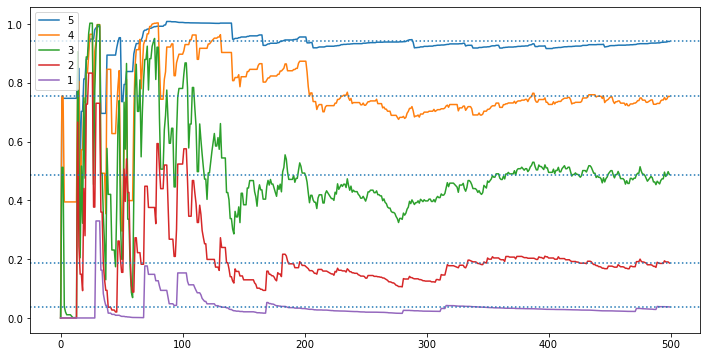

In [9]:
#value estimates through timesteps
plt.plot(mcfv[:,5])
plt.plot(mcfv[:,4])
plt.plot(mcfv[:,3])
plt.plot(mcfv[:,2])
plt.plot(mcfv[:,1])
plt.legend(['5','4','3','2','1'])

#true estimates
plt.axhline(y = mcfv[-1][1],linestyle = ':')
plt.axhline(y = mcfv[-1][2],linestyle = ':')
plt.axhline(y = mcfv[-1][3],linestyle = ':')
plt.axhline(y = mcfv[-1][4],linestyle = ':')
plt.axhline(y = mcfv[-1][5],linestyle = ':')


#### MC-EVMC

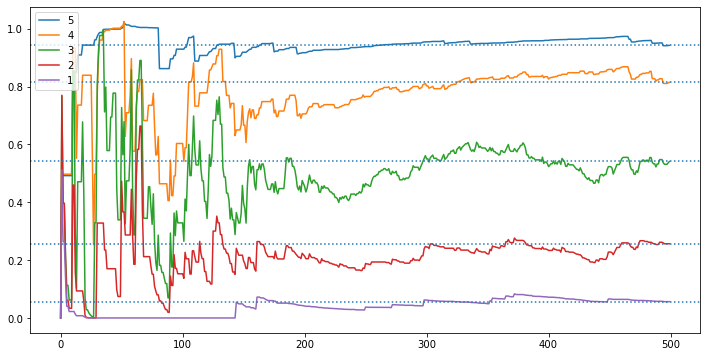

In [10]:
#value estimates through timesteps
plt.plot(mcev[:,5])
plt.plot(mcev[:,4])
plt.plot(mcev[:,3])
plt.plot(mcev[:,2])
plt.plot(mcev[:,1])
plt.legend(['5','4','3','2','1'])

#true estimates
plt.axhline(y = mcev[-1][1],linestyle = ':')
plt.axhline(y = mcev[-1][2],linestyle = ':')
plt.axhline(y = mcev[-1][3],linestyle = ':')
plt.axhline(y = mcev[-1][4],linestyle = ':')
plt.axhline(y = mcev[-1][5],linestyle = ':')


#### TD Estimates

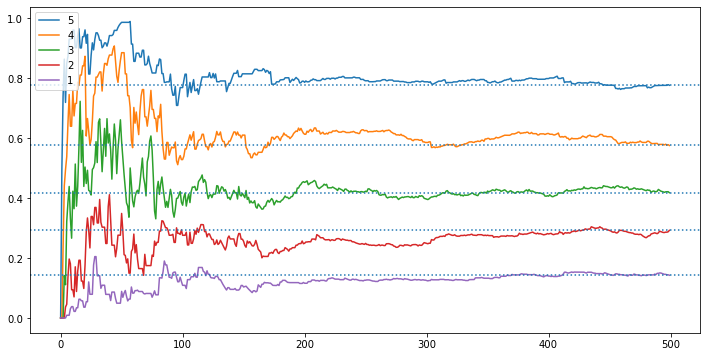

In [11]:
#value estimates through timesteps
plt.plot(td[:,5])
plt.plot(td[:,4])
plt.plot(td[:,3])
plt.plot(td[:,2])
plt.plot(td[:,1])
plt.legend(['5','4','3','2','1'])

#true estimates
plt.axhline(y = td[-1][1],linestyle = ':')
plt.axhline(y = td[-1][2],linestyle = ':')
plt.axhline(y = td[-1][3],linestyle = ':')
plt.axhline(y = td[-1][4],linestyle = ':')
plt.axhline(y = td[-1][5],linestyle = ':')


## Plots on Log Scale

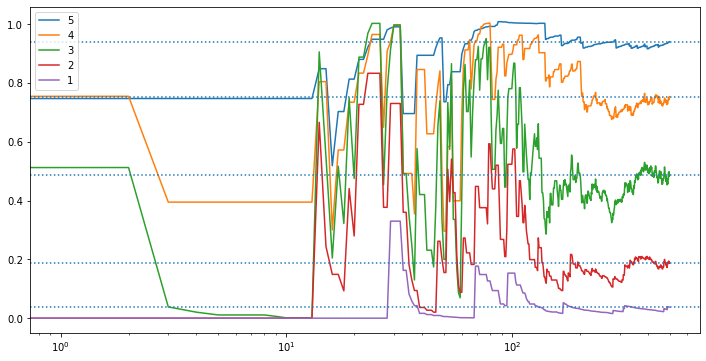

In [12]:
plt.xscale('log',base=10)
plt.plot(mcfv[:,5])
plt.plot(mcfv[:,4])
plt.plot(mcfv[:,3])
plt.plot(mcfv[:,2])
plt.plot(mcfv[:,1])
plt.legend(['5','4','3','2','1'])

#true estimates
plt.axhline(y = mcfv[-1][1],linestyle = ':')
plt.axhline(y = mcfv[-1][2],linestyle = ':')
plt.axhline(y = mcfv[-1][3],linestyle = ':')
plt.axhline(y = mcfv[-1][4],linestyle = ':')
plt.axhline(y = mcfv[-1][5],linestyle = ':')

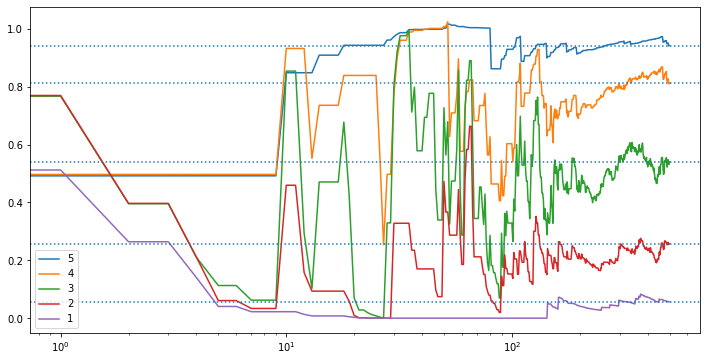

In [13]:
plt.xscale('log',base=10)
plt.plot(mcev[:,5])
plt.plot(mcev[:,4])
plt.plot(mcev[:,3])
plt.plot(mcev[:,2])
plt.plot(mcev[:,1])
plt.legend(['5','4','3','2','1'])

#true estimates
plt.axhline(y = mcev[-1][1],linestyle = ':')
plt.axhline(y = mcev[-1][2],linestyle = ':')
plt.axhline(y = mcev[-1][3],linestyle = ':')
plt.axhline(y = mcev[-1][4],linestyle = ':')
plt.axhline(y = mcev[-1][5],linestyle = ':')


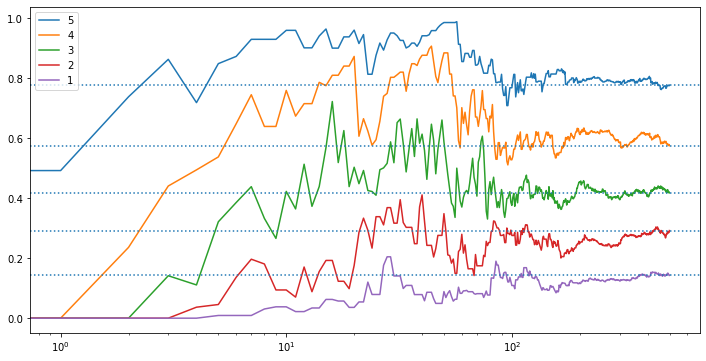

In [14]:
plt.xscale('log',base=10)
plt.plot(td[:,5])
plt.plot(td[:,4])
plt.plot(td[:,3])
plt.plot(td[:,2])
plt.plot(td[:,1])
plt.legend(['5','4','3','2','1'])

#true estimates
plt.axhline(y = td[-1][1],linestyle = ':')
plt.axhline(y = td[-1][2],linestyle = ':')
plt.axhline(y = td[-1][3],linestyle = ':')
plt.axhline(y = td[-1][4],linestyle = ':')
plt.axhline(y = td[-1][5],linestyle = ':')

## Ploting target value for state = 4

#### MC-FVMC

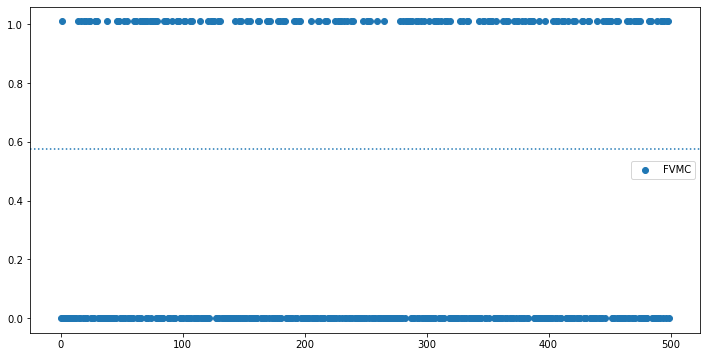

In [184]:
plt.scatter(np.arange(len(mcfv_target)),mcfv_target[:,4])
plt.legend(['FVMC'])
plt.axhline(y = td[-1][4],linestyle = ':')


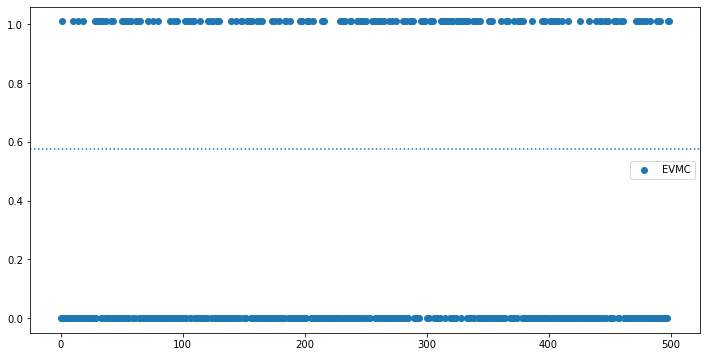

In [185]:
plt.scatter(np.arange(len(mcev_target)),mcev_target[:,4])
plt.legend(['EVMC'])
plt.axhline(y = td[-1][4],linestyle = ':')

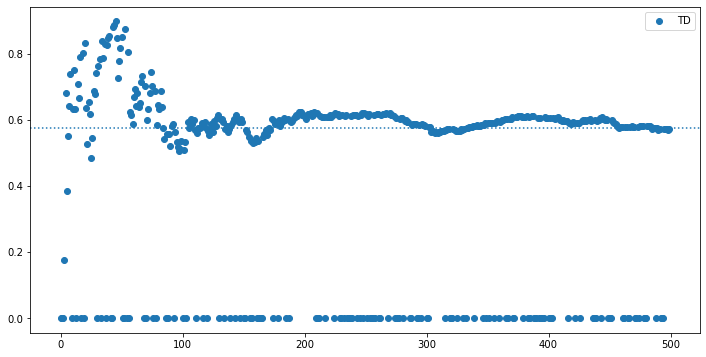

In [186]:
plt.scatter(np.arange(len(td_target)),td_target[:,4])
plt.legend(['TD'])
plt.axhline(y = td[-1][4],linestyle = ':')